# StackPro Coding Test
Yan Xu                   [04/15/2018]
## Data Description
A mega-online shopping mall provides different baby brands to customers. In order to optimize
online advertisements throughout websites, they want to predict the view-to-click probability given
the information below.
The data consists of:
1. Action: the “interaction” that users completed when online ad was exposed. There are
two types of actions in this dataset, View (a.k.a Impression) or Click.
(Reference: https://en.wikipedia.org/wiki/Impression_(online_media))
2. ID: unique user IDs
3. Action Time: the time when action (View/Click) happened, in microseconds format
4. Website: the website where the ad was published
5. Banner Size: the banner size of ad
6. Brand: the brand name that the ad was promoting
7. Colour: the colour of product showcased in the ad
8. Interaction Time: user’s interaction time with each ad (sec)


##  Task
### Goal:  Predict the Likelihood of Click
### What we would like to see in your Jupyter Notebook:

1. EDA Process (univariate/multivariate analysis, filling missing data etc.)
2. Feature Selection (select existing features and explanation)
3. Feature Engineering (create new features and explanation)
4. Select and Create Model
5. Hyper parameter Tuning if you feel it’s needed
6. Model Validation process
...


# Step 1: Data Analysis: Understanding your data

In [265]:
#import modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestClassifier # import the random forest model
from sklearn import  preprocessing # used for label encoding and imputing NaNs
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
#from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer 
from sklearn.base import BaseEstimator, RegressorMixin

# neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

from sklearn.tree import export_graphviz
# import pydotplus
import six


## Load in dataset 

In [266]:
%ls


FeatImportance.png
__MACOSX/
StackPro_Accessment_Solution_Yan.ipynb
StackPros_Assessment_DataScientist_Senior.csv
StackPros_Assessment_DataScientist_Senior.pdf
Untitled.ipynb
xgboost/
xgboost_Click_Probability.csv


In [267]:
raw_data = pd.read_csv('StackPros_Assessment_DataScientist_Senior.csv')
raw_data.head()

,Unnamed: 0,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
0,1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
1,2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
2,3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
3,4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
4,5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


In [268]:
#change the a column name 'Unnamed:0' to 'Index'
#raw_data.rename(columns = {'Unnamed: 0': 'Index'},inplace =True)
# Drop Unnamed:0 column because it does not contribute to building a model
raw_data.drop(['Unnamed: 0'], 1, inplace=True)
raw_data.dtypes

ID                  object
ActionTime           int64
Action              object
Website             object
BannerSize          object
Brand               object
colour              object
InteractionTime    float64
dtype: object

By looking at the data type of each column, we know that this dataset mainly contains catagrical features(2 numerical features and 6 catagrical features).

In [269]:
# the size of the dataset 
print ('the Shape of The Dataset',raw_data.shape)

('the Shape of The Dataset', (1000000, 8))


In [270]:

#chech how many  levels for each catagrical column
#print('Columns:',raw_data.columns.tolist())
print('Number of unique IDs:', len(raw_data.ID.unique()))
print('Number of unique Actions:', len(raw_data.Action.unique()))
print('Number of unique Websites:', len(raw_data.Website.unique()))
print('Number of unique BannerSizes:', len(raw_data.BannerSize.unique()))
print('Number of unique Brands:', len(raw_data.Brand.unique()))
print('Number of unique colours:', len(raw_data.colour.unique()))


('Number of unique IDs:', 218686)
('Number of unique Actions:', 2)
('Number of unique Websites:', 16)
('Number of unique BannerSizes:', 15)
('Number of unique Brands:', 10)
('Number of unique colours:', 7)


## The following plots show histograms of catagrical features:


Action
Click       244
View     999756
dtype: int64

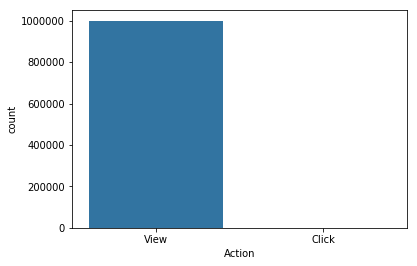

In [271]:
# As 'Action' attribute here is the label of our dataset, it is necessary to check if this dataset is balanced?

sns.countplot(raw_data.Action)
# One interesting thing is to figure out how many of records has Action attribute equal 'Click'
raw_data.groupby('Action').size()

#### This figure shows that that the dataset we have is highly imbalanced
The most possible action users taken is View, Just  a few of them actually click on ads.
Therefore, we might need to look into that when sampling training set and testing set. We need to keep this in mind when performing modelling and evaluation.




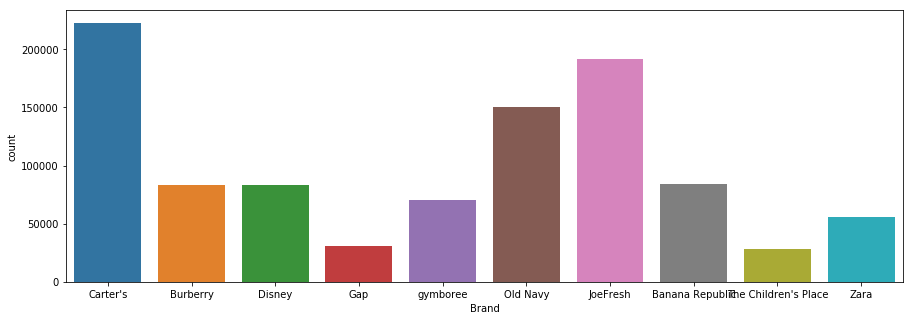

In [272]:
fig=plt.figure(figsize=(15,5))
sns.countplot(raw_data.Brand)

###  As for the 'brand' feature, we cannot find somthing that we need topay attention to

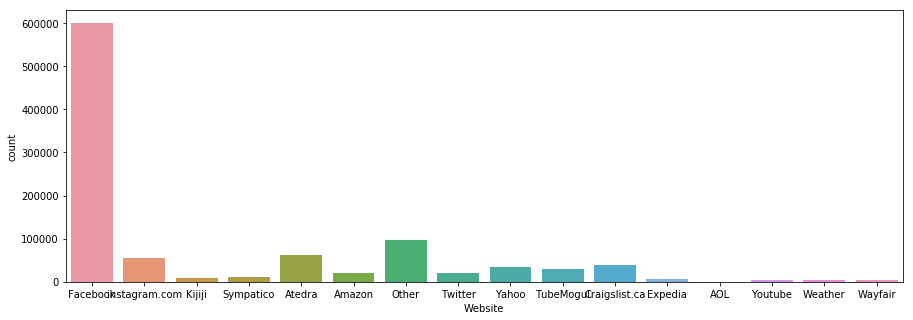

In [273]:
fig=plt.figure(figsize=(15,5))
sns.countplot(raw_data.Website)

### We can find that the majority of the ads were exposed on Facebook according to our dataset

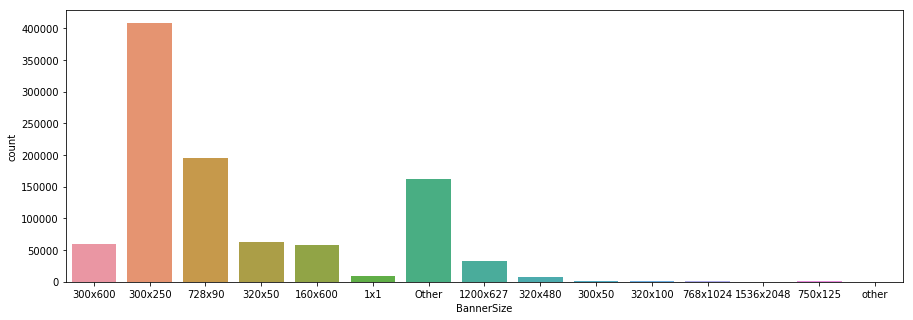

In [274]:
fig=plt.figure(figsize=(15,5))
sns.countplot(raw_data.BannerSize)

#### Note here, there are two factors[other, Other], they should represents the same meaning
This will be solved later

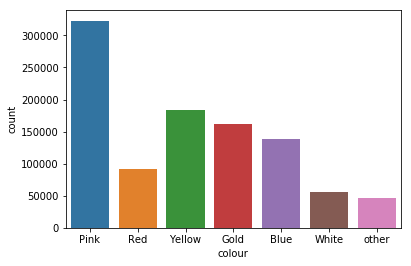

In [275]:
#fig=plt.figure(figsize=(20,10))
sns.countplot(raw_data.colour)

###  As for the 'Colour' feature, we cannot find somthing that we need topay attention to.

## Several Observations
From above results, few things can be found:

1. The Number of unique IDs is greater than the number of our records, which means one user might view ads more than once. The dataset contains more than two records for a unique user.

2. At this stage, I discovered a problem, which is the BannerSizes feature, the intuition is that the bigger the banner size, there are higer probabilities that user will click on ads. Intrincally, it should not be catagrical feature, instead, it might be better to convert it to numberical feature, This is where I can do Feature Engineering later on.

3. The two features, colour and BannerSize contain 'other' catagory, this is not a big problem, Regaring to colour feature, we can regard the ''other catagory as a new catagory. Regaring to BannerSize feature, we will solve this when we perform feature engineering. 

4. After looking at the distribution plots of catagorical features, we can conclude that there are no missing values in catagorical features



# Feature Engineering

As mentioned before, BannerSize feature is a feature we might need to introduce a feature--'BannerArea' 

In [276]:
# fist we need to deal calculate BannerArea, we will regard 'other' or 'Other' factors as missing values in this column
sizes= raw_data.BannerSize.unique()
# As there are just several possible banner sizes, we can calculate the possible area and then infer these values 
#to new BannerArea feature 
#define a method to calculate area of banner 
sizes = sizes.tolist()
new_dir = {}
for i, size in enumerate(sizes):
    if size =='Other' or size == 'other':
        new_dir[i]= 0  
    else:
        a= size.split('x')
        area = int(a[0])*int(a[1])
        new_dir[i] = area        
for i, size in enumerate(sizes):
    mask = raw_data.BannerSize == size
    column_name = 'BannerSize'
    raw_data.loc[mask, column_name] = new_dir[i]
    
# change the feayture name
raw_data.rename(columns = {'BannerSize': 'BannerArea'},inplace =True)   

raw_data.head()




,ID,ActionTime,Action,Website,BannerArea,Brand,colour,InteractionTime
0,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,180000,Carter's,Pink,0.171601
1,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,75000,Burberry,Red,4.303945
2,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,65520,Disney,Yellow,0.868106
3,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,16000,Carter's,Yellow,0.802647
4,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,75000,Gap,Gold,0.627148


In [277]:
#df[['two', 'three']] = df[['two', 'three']].astype(float)
raw_data[['BannerArea']] = raw_data[['BannerArea']].astype(float)

raw_data.loc[raw_data['BannerArea'] == 0,'BannerArea'] = np.nan




In [278]:
raw_data.BannerArea.isnull().unique()

array([False,  True], dtype=bool)


# Step 2: Missing value checking and dealing with missing values  

Defined a finction to check of there are missing values in a cenrtain feature

In [279]:
def CheckMissingValues(feature):
    cc =raw_data[feature].isnull().unique()
    if len(cc) == 1: #if length=1 means return only false,so there are no misssing values
        print 'There are no missing values in feature: %s'%feature
    else:
        print 'Alert！ There are missing values in feature:  %s'%feature

column_list = raw_data.columns.tolist()
# check if feature has missing values
for i in column_list:
    CheckMissingValues(i)


There are no missing values in feature: ID
There are no missing values in feature: ActionTime
There are no missing values in feature: Action
There are no missing values in feature: Website
Alert！ There are missing values in feature:  BannerArea
There are no missing values in feature: Brand
There are no missing values in feature: colour
Alert！ There are missing values in feature:  InteractionTime


#### Addressing problems with NaN in the data

As we saw from our EDA there were NaN in feature: InteractionTime. Our model won't know what to do with these so we need to replace them with something sensible.

There are quite a few options we can use - the mean, median, most_frequent, or a numeric value like 0. Playing with these will give different results, for now I have it set to use the mean.

This uses the mean of the column in which the missing value is located.

In [280]:
# Create a list of columns that have missing values and an index (True / False)
df_missing = raw_data.isnull().sum(axis = 0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
idx_ = df_missing['missing_count'] > 0
df_missing = df_missing.loc[idx_]

cols_missing = df_missing.column_name.values
idx_cols_missing = raw_data.columns.isin(cols_missing)
print df_missing # this will count the number of missing values in our dataset


       column_name  missing_count
4       BannerArea         162246
7  InteractionTime              8


As there are only 8 missing values in InteractionTime, Therefore, the way of dealing with missing values won't affect prediction results too much 

In [281]:
# Instantiate an imputer
imputer = preprocessing.Imputer(missing_values='NaN', strategy = 'mean', axis = 0)

# Fit the imputer using all of our data (but not any dates)
imputer.fit(raw_data.loc[:, idx_cols_missing])

# Apply the imputer
raw_data.loc[:, idx_cols_missing] = imputer.transform(raw_data.loc[:, idx_cols_missing])


In [282]:
#check again if missing values are filled already?
print 'After dealing with missing values'
CheckMissingValues('InteractionTime')
CheckMissingValues('BannerArea')
#let's take a look at the histogram of the two numerical data 
# let's take a look at the distrinution of data


After dealing with missing values
There are no missing values in feature: InteractionTime
There are no missing values in feature: BannerArea


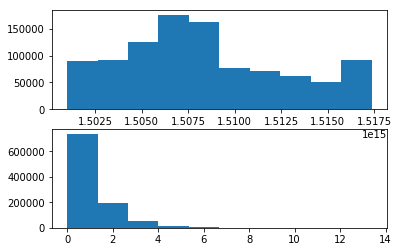

In [283]:
import matplotlib.pyplot as plt
# plot a line, implicitly creating a subplot(111)


# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.subplot(212)
plt.hist(raw_data['InteractionTime']);
plt.subplot(211) # creates 2nd subplot with yellow background
plt.hist(raw_data['ActionTime']);

#### This figure shows the histograms of ActionTime and Interaction time

## Encoding categorical features
We will take a naive approach and assign a numeric value to each categorical feature in our dataset. Sklearn's preprocessing unit has a tool called LabelEncoder() which can do just that for us.

In [284]:

# extract the label column:
labels = raw_data[['Action']]

df_fea = raw_data.drop(["Action"], axis=1)
# encoding categorical features
for c in df_fea.columns:
    if df_fea[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_fea[c].values)) 
        df_fea[c] = lbl.transform(list(df_fea[c].values))
#encoding label column: click=1,view =0
labels = labels.Action.map(dict(Click=1, View=0)).to_frame();

print type(labels)
print df_fea.shape
df_fea.head()

#split the data into train set and test set

<class 'pandas.core.frame.DataFrame'>
(1000000, 7)


,ID,ActionTime,Website,BannerArea,Brand,colour,InteractionTime
0,185287,1508761859495365,5,180000.0,2,2,0.171601
1,89056,1502847469736117,5,75000.0,1,3,4.303945
2,44526,1514169431528120,5,65520.0,3,5,0.868106
3,148601,1515527952591896,5,16000.0,2,5,0.802647
4,210803,1507514809374045,15,75000.0,4,1,0.627148


## Multivariate Analysis
#### Use  the correlation matrix to check if data has multicolinearity 

,ID,ActionTime,Website,BannerArea,Brand,colour,InteractionTime
ID,1.000000,0.005492,-0.014643,-0.005110,0.000837,-0.000189,0.000294
ActionTime,0.005492,1.000000,-0.072466,-0.136278,0.000056,0.000037,-0.000396
Website,-0.014643,-0.072466,1.000000,0.296087,-0.001241,0.000620,0.001795
BannerArea,-0.005110,-0.136278,0.296087,1.000000,-0.002021,0.000187,-0.000381
Brand,0.000837,0.000056,-0.001241,-0.002021,1.000000,0.001227,0.000871
colour,-0.000189,0.000037,0.000620,0.000187,0.001227,1.000000,-0.001400
InteractionTime,0.000294,-0.000396,0.001795,-0.000381,0.000871,-0.001400,1.000000


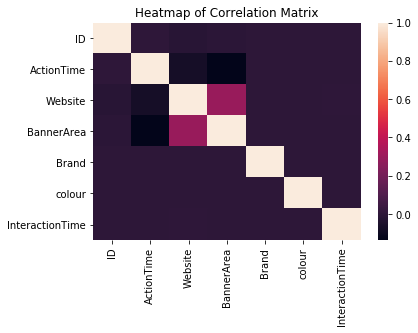

In [285]:
#Correlation Matrix
corr = df_fea.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

#### This correlation matrix shows there features are not correlated to each other, which is good, we might not need to deal with correlated features

## Split Dataset into train set and test set by using stratified sampling 
As the dataset is imbalanced and we want to evaluate the model performance on both 'Action' equally, Therefore, dividing the dataset into train and test sets using stratified sampling is necessary

Here, 80% of the data are used for training models and the rest of them are used for testing 



In [286]:
# split data into train set and test set;
X_train, X_test, y_train, y_test = train_test_split(df_fea, labels, test_size=0.2, stratify=labels)


In [287]:
type(X_train)

pandas.core.frame.DataFrame


# Feature Selection

### At the very begining, we can use a random forest classifier to do feature selection 


/home/lein/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


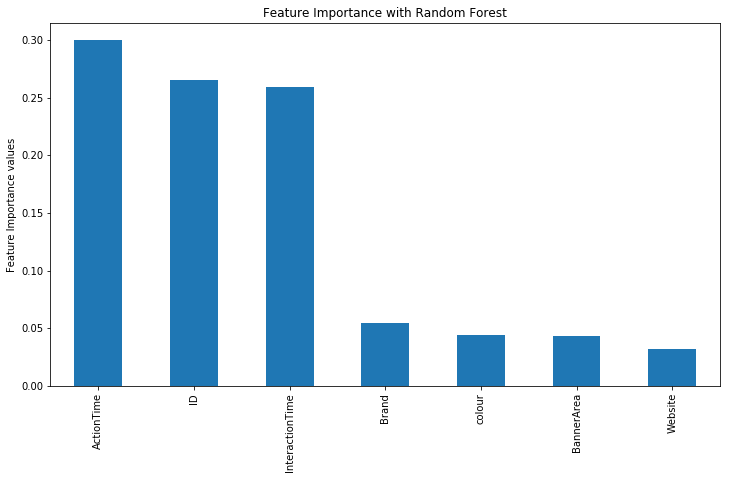

In [288]:
# Define a classifier
rf_clf = RandomForestClassifier(max_depth=15,n_estimators=70, min_samples_leaf=50,
                                  min_samples_split=100, random_state=10)

# Train the model
rf_clf.fit(X_train,y_train)

# Plot the top 40 important features
imp_feat_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp_feat_rf.plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

### Observesion of importance of features. 
1. we can find that ActionTime, InteractionTime and user ID are the top 3 important features among all the features.  
2. One interesting finding is website is an insignificant feature accoring to this figure, However, our intuition is the click-through-rate might be related to which wensite the ads were exposed because we need to spend more money on popular webisite like Facebook in order to put on ads. 

At this stage, we cannot conclude that website is a unimportant feature, In order to get more confidence, Let us try few more feature selection methods

### Therefore I use XGBoost regressor to generate the rank of "feature importance"

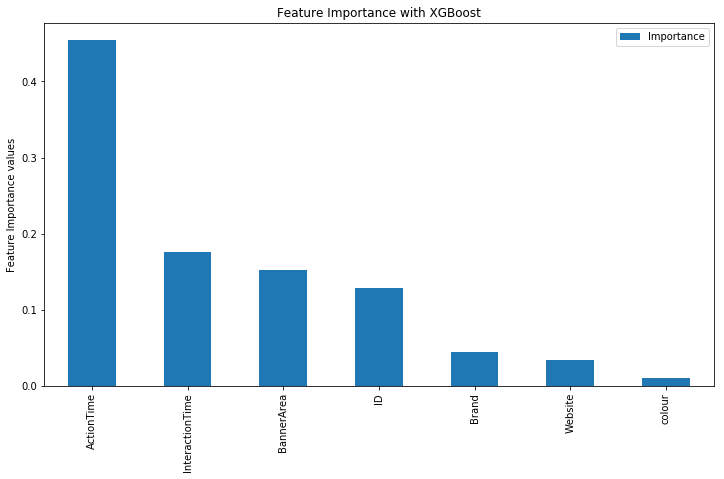

In [289]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
imp = pd.DataFrame(xgb.feature_importances_ ,columns = ['Importance'],index = X_train.columns)
imp = imp.sort_values(['Importance'], ascending = False)

imp.plot(kind='bar', title='Feature Importance with XGBoost', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.show()

#### The feature importance results from XGBoost is a little bit different, but the top three most important features are the same, 


##  Now we can use RFECV to eliminate the redundant features(i.e. Select features).


The following are what I did originally to select features. I ran a loop and use XGBoost regressor with cross validation to see the improvement of Root-Mean-Squared-Error as a function of the number of features included. This method is essentially the RFECV algorithm).



In [290]:
# Define a function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true-y_pred)**2))

# Define a function to calculate negative RMSE (as a score)
def nrmse(y_true, y_pred):
    return -1.0*rmse(y_true, y_pred)

neg_rmse = make_scorer(nrmse)

estimator = XGBRegressor()
selector = RFECV(estimator, cv = 3, n_jobs = -1, scoring = neg_rmse)
selector = selector.fit(X_train, y_train)

print("The number of selected features is: {}".format(selector.n_features_))

features_kept = X_train.columns.values[selector.support_] 
print 'the selected features are the followings'
print features_kept

X_train = selector.transform(X_train)  
X_test = selector.transform(X_test)
print type(X_train)

The number of selected features is: 7
the selected features are the followings
['ID' 'ActionTime' 'Website' 'BannerArea' 'Brand' 'colour'
 'InteractionTime']
<type 'numpy.ndarray'>


### At this stage, the feature selection part is done

# Model Selection and Model Evaluation
## --Cross-validation with stratification based on class labels.

One thing we need to clarify is that our goal is to estimate the probability of click on ads. This a regression problem instead of classifiction problem: 
1. As our dataset almost consists of catagrical features, and we know that tree-based method perform well on categrical data

2. we need to adopt cross-validation with stratification becasue of our imbalanced dataset 

2. Therefore, I decided to implement three-basned regression models first(we can choose more than three models if we want, but three models are enough for now to show an example of model selection using cross-validation. beside, becasue of my computer's memory restriction, I am unable to perform cross-validation for  more models)

3. After evaluate their performance with the averaged L2 loss through cross-validation, we can pick the one has lowest loss as our final model.

4. After performing the above, we will do hyperparameter tuning to achieve a lower loss.(better model)

Let us try a decision tree first.


In [291]:
# before get started, we need to split data into subsets. 
#hus, let us combine X_train, X_test, y_train and y_test together 

X=np.vstack((X_train,X_test))
y=np.vstack((y_train,y_test))


In [238]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree

## Start with stratified 10 folde cross-validation for 
skf = StratifiedKFold(n_splits=10)
tree_mse_list =[]

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = tree.DecisionTreeRegressor().fit(X_train, y_train)
    mse = mean_squared_error(y_test, clf.predict(X_test))
    tree_mse_list.append(mse)
   



In [160]:
#let's try a more advanced boosting model GradientBoostingRegressor

GBR_mse_list=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, 
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
    pred = est.predict(X_test)
    mse = mean_squared_error(y_test, est.predict(X_test))
    GBR_mse_list.append(mse)
    


In [163]:
# XGBoost with 10-fold- stratified cross validation
XGB_mse_list=[]
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, subsample=0.5, colsample_bytree=0.5, 
                   max_depth=3, gamma=0, reg_alpha=0, reg_lambda=2, min_child_weight=1).fit(X_train, y_train)
    pred = xgb.predict(X_test)
    mse = mean_squared_error(y_test, xgb.predict(X_test))
    XGB_mse_list.append(mse)

## Summary of three regression models

In [165]:
print 'The Cross_validation LOSS of decision tree regressor is'
print np.mean(tree_mse_list)
print 'The Cross_validation LOSS of GradientBoosting Regressor is'
print np.mean(GBR_mse_list)
print 'The Cross_validation LOSS of XGBRegressor is'
print np.mean(XGB_mse_list)


The Cross_validation LOSS of decision tree regressor is
0.000457000270037
The Cross_validation LOSS of GradientBoosting Regressor is
0.000243897601461
The Cross_validation LOSS of XGBRegressor is
0.000243081547549


### As the loss of  XGBRegressor is the lowest according to cross-validation results. Therefore, we will choose  XGBRegressor  among the three models

# Step 4: Hyperparameter tuning 


1. The hyperparameters of these regressors were tuned using GridSearchCV. 

2. Again, becasue of my computer computational ability is not good, it is very slow to run GridSearchCV over many different options of parameters. Therefore, I did not try different parameters a lot, but we can get the idea of hyperparameter tuning


In [181]:
params={
    'max_depth': [3,5], # 5 is good but takes too long in kaggle env
    #'subsample': [0.3,0.5],
    #'colsample_bytree': [0.5,0.8],
    'n_estimators': [500,100],
    #'reg_alpha': [0.01, 0]
}
xgb_clf = XGBRegressor()
rs = GridSearchCV(xgb_clf,
                  params,
                  cv=5,
                  scoring="neg_mean_squared_error",
                  n_jobs=1,
                  verbose=2)
rs.fit(X_train, y_train)
best_est = rs.best_estimator_
print(best_est)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] n_estimators=500, max_depth=3 ...................................
[CV] .................... n_estimators=500, max_depth=3, total= 1.7min
[CV] n_estimators=500, max_depth=3 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] .................... n_estimators=500, max_depth=3, total= 1.7min
[CV] n_estimators=500, max_depth=3 ...................................
[CV] .................... n_estimators=500, max_depth=3, total= 1.7min
[CV] n_estimators=500, max_depth=3 ...................................
[CV] .................... n_estimators=500, max_depth=3, total= 1.6min
[CV] n_estimators=500, max_depth=3 ...................................
[CV] .................... n_estimators=500, max_depth=3, total= 1.6min
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  19.3s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  19.2s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .................... n_estimators=100, max_depth=3, total=  19.3s
[CV] n_estimators=100, max_depth=3 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 28.4min finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


### After finding the best parameters, Now we can use these parameter in the XGBoosting regression model
next, we will use this model to make the final prediction on test set and computet the losses for each records in the test set and save these prediction into a csv file

### Finally, as we already have the labels for the test set, we can compute the L2 loss 

In [236]:
# change several paramters as the best options and the we will use this as the final model

xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1).fit(X_train, y_train)




# When we have some data need to predict the probabiity of click, we can use this mode 

#### Note that the following code is for the new data that need to perform prediction; the following  code won't work 

#### The new data need to go through the data preproceiing steps, then we can use this model to predict the probability of click 


In [ ]:
X_pred = pd.read_csv('./ ....')
pred = xgb.predict(X_pred)
mse = mean_squared_error(y_test, xgb.predict(X_test))

In [233]:

cilck_probs = pred

#generate the dataFrame we want to save.
pred= np.reshape(pred, (pred.shape[0], 1)) 
test_arr = np.hstack((X_test,y_test,pred))
col =raw_data.columns.tolist()
colu =col+['Prob_Click']
df_re= pd.DataFrame(test_arr,columns=colu)
## Save the prediction results to a .csv file as dataframe
save_results = df_re
save_results.to_csv("xgboost_Click_Probability.csv", index=False)




# Summary 

## In order to predict the view-to-click probability of online ads, the following steps are taken:

### 1. Data analysis and data wrangling
### 2. Feature Selection and Feature Engineering
### 3. Model Selection and Model building 
### 4. Model Evaluation and Hyperparameter Tuning 

Thanks for giving me this opportunity, any feedback will be appreciate.
